In [70]:
import cv2
import os
import random 
random.seed(42)
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()
print(random.random())
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from torch.utils.data import ConcatDataset

0.6394267984578837


In [62]:
IMG_SIZE = 128
num_classes = 3
train_dir = r'C:\Users\dkang\OneDrive\Documents\Gray Scale Image Code\Conductor_research\Image\GVN\CNN_GVN_Train_Img'
test_dir = r'C:\Users\dkang\OneDrive\Documents\Gray Scale Image Code\Conductor_research\Image\GVN\CNN_GVN_Test_Img'

batch_size=32 #standard batch size; smaller the better at generalization
X_train = []
y_train = []

for folder in os.scandir(train_dir):
    count = 0  # Initialize count to 0
    for entry in os.scandir(train_dir + '/' + folder.name):
        img = cv2.imread(train_dir + '/' + folder.name + '/' + entry.name, cv2.IMREAD_GRAYSCALE)  # Read image using OpenCV
        print(train_dir + folder.name + '/' + entry.name, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize image to specified size
        img = np.array(img, dtype='float32')  # Convert image to float32 type
        img = img/255  # Normalize pixel values to range [0, 1]

        X_train.append(img)  # Append image to training data

        if folder.name == 'only_cor':
            y_train.append(0)  # Assign class label 0 for 'only corroded' 
        elif folder.name == 'only_def':
            y_train.append(1)  # Assign class label 1 for 'only defective' 
        elif folder.name == 'def_cor':
            y_train.append(2)  # Assign class label 2 for 'defective & corroded'

        count += 1  # Increment count for each image

    print(f"Folder: {folder.name}, Total Training Images: {count}")

X_train = np.array(X_train)  # Convert training data to numpy array
y_train = np.array(y_train)  # Convert class labels to numpy array
# Add a channel dimension since the images are grayscale
X_train = np.expand_dims(X_train, axis=-1)

datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    vertical_flip=True)  

num_augmented_samples = 1000  # Desired total number of augmented samples
steps_per_epoch = num_augmented_samples // batch_size

X_aug_list = []
y_aug_list = []

for _ in range(steps_per_epoch):
    X_batch, y_batch = next(datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True, seed = 42))
    X_aug_list.append(X_batch)
    y_aug_list.append(y_batch)

X_aug = np.concatenate([X_train] + X_aug_list, axis=0)
y_aug = np.concatenate([y_train] + y_aug_list, axis=0)


print(f"Original training data shape: {X_train.shape}")
print(f"Original training data shape: {y_train.shape}")

print(f"Augmented training data shape: {X_aug.shape}")
print(f"Augmented training Y data shape: {y_aug.shape}")


C:\Users\dkang\OneDrive\Documents\Gray Scale Image Code\Conductor_research\Image\GVN\CNN_GVN_Train_Imgdef_cor/GVN_11.jpg.png 0
C:\Users\dkang\OneDrive\Documents\Gray Scale Image Code\Conductor_research\Image\GVN\CNN_GVN_Train_Imgdef_cor/GVN_12.jpg.png 0
C:\Users\dkang\OneDrive\Documents\Gray Scale Image Code\Conductor_research\Image\GVN\CNN_GVN_Train_Imgdef_cor/GVN_13.jpg.png 0
C:\Users\dkang\OneDrive\Documents\Gray Scale Image Code\Conductor_research\Image\GVN\CNN_GVN_Train_Imgdef_cor/GVN_14.jpg.png 0
C:\Users\dkang\OneDrive\Documents\Gray Scale Image Code\Conductor_research\Image\GVN\CNN_GVN_Train_Imgdef_cor/GVN_15.jpg.png 0
C:\Users\dkang\OneDrive\Documents\Gray Scale Image Code\Conductor_research\Image\GVN\CNN_GVN_Train_Imgdef_cor/GVN_17.jpg.png 0
C:\Users\dkang\OneDrive\Documents\Gray Scale Image Code\Conductor_research\Image\GVN\CNN_GVN_Train_Imgdef_cor/GVN_19.jpg.png 0
C:\Users\dkang\OneDrive\Documents\Gray Scale Image Code\Conductor_research\Image\GVN\CNN_GVN_Train_Imgdef_cor/G

In [72]:
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=True, stratify=y_train, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_aug, y_aug, test_size=0.25, shuffle=True, stratify=y_aug, random_state=42)

# K-cross validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
# Lists to store metrics
acc_per_fold = []
loss_per_fold = []

fold_no = 1
for train_index, val_index in kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model = tf.keras.Sequential([
        # Input layer: assuming the input image size is (IMG_SIZE, IMG_SIZE, 1) for grayscale images
        Conv2D(filters=16, kernel_size=(7, 7), activation='relu', kernel_initializer=initializer, input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),
        Flatten(), #Flatten the 3D tensor to 1D
        # Fully connected layers
        Dense(100, activation='relu'),
        Dropout(0.15),
        Dense(667, activation='relu'), #100/.15 = 667 to compensate for the loss through dropout
        Dense(3, activation='softmax')  # Assuming 3 classes for classification
    ])
    initializer = tf.keras.initializers.GlorotUniform(seed=42)
    opt = optimizers.Adam(learning_rate=0.0003)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # Train the model
    checkpointer = ModelCheckpoint(filepath="main.keras", verbose=1, save_best_only=True)
    history = model.fit(X_train_fold, 
                        y_train_fold, 
                        epochs=20, 
                        validation_data=(X_val_fold, y_val_fold), 
                        batch_size=32, 
                        shuffle=True, 
                        callbacks=[checkpointer])

    # Generate generalization metrics
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1
    

# After k-cross validation, train on the entire training data
model = tf.keras.Sequential([
    # Input layer: assuming the input image size is (IMG_SIZE, IMG_SIZE, 1) for grayscale images
    Conv2D(filters=16, kernel_size=(7, 7), activation='relu', kernel_initializer=initializer, input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Flatten(), #Flatten the 3D tensor to 1D
    # Fully connected layers
    Dense(100, activation='relu'),
    Dropout(0.15),
    Dense(667, activation='relu'), #100/.15 = 667 to compensate for the loss through dropout
    Dense(3, activation='softmax')  # Assuming 3 classes for classification
])
initializer = tf.keras.initializers.GlorotUniform(seed=42)
opt = optimizers.Adam(learning_rate=0.0003)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

# Compute the expected initial loss for a softmax classifier
expected_initial_loss = -np.log(1.0 / num_classes)
print(f"Expected Initial Loss: {expected_initial_loss:.6f}")

#Measure the actual initial loss on the validation set before training
initial_loss, initial_accuracy = model.evaluate(X_val, y_val, batch_size=32)
print(f"Actual Initial Loss: {initial_loss:.6f}")
print(f"Actual Initial Accuracy: {initial_accuracy:.6f}")

checkpointer = ModelCheckpoint(filepath="main.keras", verbose=1, save_best_only=True)

#Train the model
# with augmentation 
history = model.fit(X_aug, y_aug, epochs=20, validation_data=(X_val, y_val), batch_size=32, shuffle=True, callbacks=[checkpointer])
# without augmentation
# history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32, shuffle=True, callbacks=[checkpointer])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(len(acc_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')

print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20


C:\Users\dkang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6059 - loss: 0.9187
Epoch 1: val_loss improved from inf to 0.61945, saving model to main.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.6068 - loss: 0.9169 - val_accuracy: 0.7710 - val_loss: 0.6195
Epoch 2/20
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7867 - loss: 0.5648
Epoch 2: val_loss improved from 0.61945 to 0.40420, saving model to main.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7874 - loss: 0.5628 - val_accuracy: 0.8550 - val_loss: 0.4042
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8585 - loss: 0.3540
Epoch 3: val_loss improved from 0.40420 to 0.34605, saving model to main.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8586 - loss: 0.3539 - val_accuracy: 0.8702 - val_loss: 0.3460
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9104 - loss: 0.2564
Epoch 4: val_loss improved from 0.34605 to 0.32198, saving model to main.keras
37/37 ━━━━━

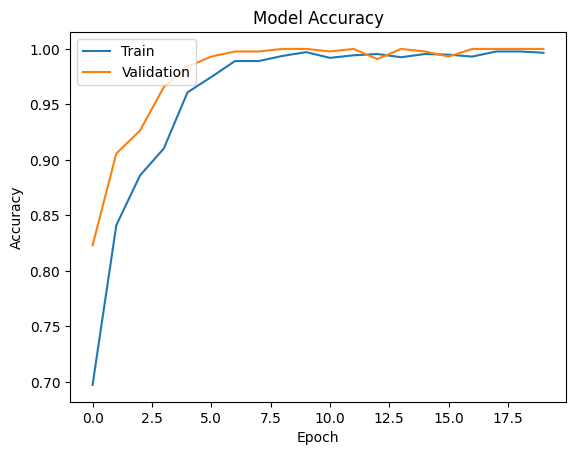

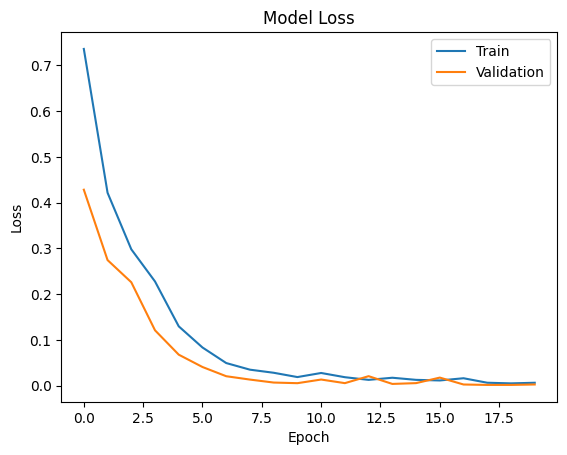

In [73]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [75]:
X_test = []
y_test = []

for folder in os.scandir(test_dir):
    for entry in os.scandir(test_dir + '/' + folder.name):
        img = cv2.imread(test_dir + '/' + folder.name + '/' + entry.name, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = np.array(img, dtype='float32')
        img = img / 255

        X_test.append(img)

        if folder.name == 'only_cor':
            y_test.append(0)
        elif folder.name == 'only_def':
            y_test.append(1)
        elif folder.name == 'def_cor':
            y_test.append(2)

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"X test data shape: {X_test.shape}")
print(f"Y test data shape: {y_test.shape}")


# Number of classes in your classification problem
num_classes = 3

# Convert to one-hot encoding
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

model.load_weights("main.keras")

# Evaluate the model on test data
y_test_sparse = np.argmax(y_test_one_hot, axis=1)
loss, accuracy = model.evaluate(X_test, y_test_sparse, batch_size=32)


X test data shape: (251, 128, 128)
Y test data shape: (251,)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9436 - loss: 0.2839


In [88]:
from sklearn.metrics import classification_report
# Generate classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
class_names = ['only_cor', 'only_def', 'def_cor']  # Replace with your class names
report = classification_report(y_test, y_pred_classes, target_names=class_names)
print(report)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
              precision    recall  f1-score   support

    only_cor       0.97      0.98      0.98       133
    only_def       0.96      0.94      0.95        83
     def_cor       0.94      0.94      0.94        35

    accuracy                           0.96       251
   macro avg       0.96      0.96      0.96       251
weighted avg       0.96      0.96      0.96       251



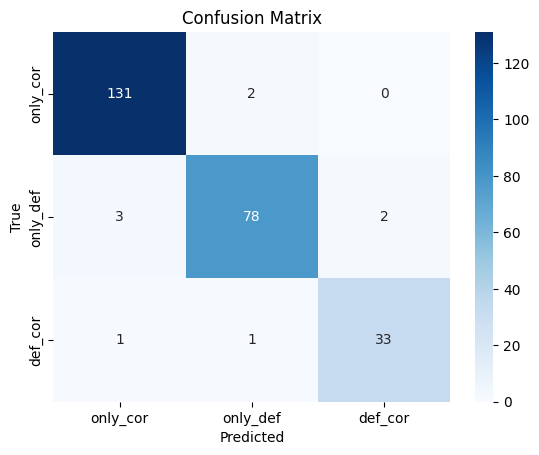

In [89]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import random

# test directory path and class names
class_names = ['Covid', 'Viral Pneumonia', 'Normal']

# Randomly display 3 images from test folders
for i in range(3):
    folder_name = random.choice(['Covid', 'Viral Pneumonia', 'Normal'])
    image_name = random.choice(os.listdir(test_dir + folder_name))
    image_path = os.path.join(test_dir, folder_name, image_name)

    # Load and display the selected image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Preprocess the image for prediction
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = np.array(image, dtype='float32')
    image = image / 255
    image = np.expand_dims(image, axis=0)

    # Make predictions using the model
    predictions = model.predict(image)
    predicted_class_index = np.argmax(predictions, axis=1)
    predicted_class_name = class_names[predicted_class_index[0]]

    # Print true class and predicted class
    print('True Class:', folder_name)
    print('Predicted Class:', predicted_class_name)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the tflite model to a file
with open('main.tflite', 'wb') as f:
    f.write(tflite_model)